<a href="https://colab.research.google.com/github/ascle/colab_tcc2/blob/dev/5_modelagem-classificacao_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importando bibliotecas<hr style='border: 2px solid red;'>


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

### Outras configurações<hr style='border: 2px solid red;'>



In [2]:
!pip install ipython-autotime
pd.set_option('display.max_columns', None)
%load_ext autotime

SEED = 7
np.random.seed(SEED)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.6 MB/s eta 0:00:00
time: 516 µs (started: 2023-09-06 11:09:30 +00:00)


### Conectando no ambiente que será utilizado<hr style='border: 2px solid red;'>


In [3]:
# Importando do Drive
from google.colab import drive
from os import chdir

drive.mount('/content/drive', force_remount=True)
chdir('/content/drive/MyDrive/UFS/tcc-2-ascle-ufs/bases/linkage_marco/')

Mounted at /content/drive
time: 22.8 s (started: 2023-09-06 11:09:30 +00:00)


#### Leitura dos dados

In [4]:
data_raw = pd.read_csv('dn_etl.csv', sep=';', low_memory=False)
data_raw.sort_index(axis=1, inplace=True)

time: 2.14 s (started: 2023-09-06 11:09:54 +00:00)


In [5]:
data_raw.shape

(190020, 24)

time: 6.63 ms (started: 2023-09-06 11:09:56 +00:00)


In [6]:
data_raw.head()

,ANO,APGAR1,APGAR5,CODANOMAL_QTD,CONSPRENAT,ESCMAEETL_VALOR,ESTCIVMAE_COMPANHEIRO,GRAVIDEZ_VALOR,LOCNASC_DOMICILIO,LOCNASC_ESTAB_SAUDE,LOCNASC_HOSPITAL,LOCNASC_OUTROS,OBT_NEONATAL,PARTO_CESAREO,PARTO_VAGINALL,PESO,QTDFILMORT,QTDPARTCES,SEMAGESTAC,SEXO_FEM,SEXO_MASC,TPAPRESENT_CEFALICO,TPAPRESENT_PELVICO,TPAPRESENT_TRANSVERSA
0,2015,2.0,4.0,0.0,5.0,1,0,1,0,0,1,0,0,1,0,820.0,1.0,NaN,26.0,0,1,1,0,0
1,2015,9.0,10.0,0.0,8.0,4,1,1,0,0,1,0,0,1,0,4200.0,1.0,NaN,39.0,0,1,1,0,0
2,2015,7.0,8.0,0.0,10.0,11,1,1,0,0,1,0,0,0,1,3700.0,0.0,0.0,40.0,1,0,1,0,0
3,2015,7.0,8.0,0.0,7.0,4,0,1,0,0,1,0,0,0,1,3550.0,1.0,0.0,37.0,0,1,1,0,0
4,2015,9.0,10.0,0.0,3.0,11,0,1,0,0,1,0,0,1,0,3800.0,0.0,NaN,39.0,1,0,1,0,0


time: 81 ms (started: 2023-09-06 11:09:56 +00:00)


## Dados X e y<hr style='border: 2px solid red;'>

In [7]:
X_raw= data_raw.drop(columns=['QTDPARTCES', 'ANO', 'OBT_NEONATAL'])
y_raw= data_raw["OBT_NEONATAL"]

time: 35.4 ms (started: 2023-09-06 11:09:56 +00:00)


## Dados desbalanceados<hr style='border: 2px solid red;'>

https://imbalanced-learn.org/stable/introduction.html

https://medium.com/data-hackers/como-lidar-com-dados-desbalanceados-em-problemas-de-classifica%C3%A7%C3%A3o-17c4d4357ef9

https://medium.com/turing-talks/dados-desbalanceados-o-que-s%C3%A3o-e-como-evit%C3%A1-los-43df4f49732b

https://www.teses.usp.br/teses/disponiveis/55/55134/tde-06012016-145045/publico/VictorHugoBarella_dissertacao_revisada.pdf

https://www.hashtagtreinamentos.com/datasets-desbalanceados-ciencia-dados


In [8]:
from imblearn.over_sampling import SMOTE

time: 664 ms (started: 2023-09-06 11:09:56 +00:00)


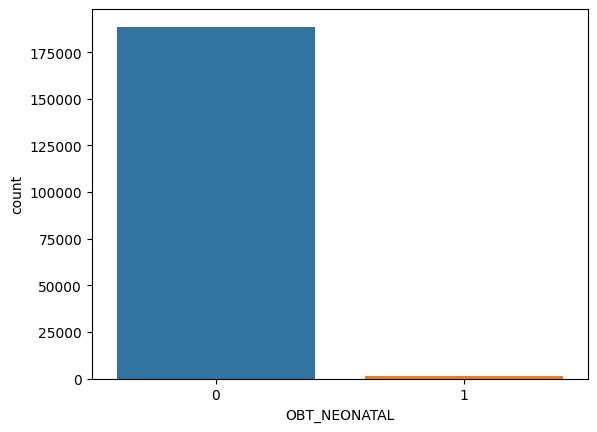

time: 873 ms (started: 2023-09-06 11:09:57 +00:00)


In [9]:
ax = sns.countplot(x='OBT_NEONATAL', data=data_raw)

#### Oversampling Smote

https://arxiv.org/abs/1106.1813

Consiste em criar observações intermediárias entre dados parecidos

In [10]:
smt = SMOTE(random_state=SEED)
X_bal, y_bal = smt.fit_resample(X_raw, y_raw)

time: 700 ms (started: 2023-09-06 11:10:12 +00:00)


In [11]:
data_bal = pd.concat([X_bal, y_bal], axis=1)

time: 68.8 ms (started: 2023-09-06 11:10:13 +00:00)


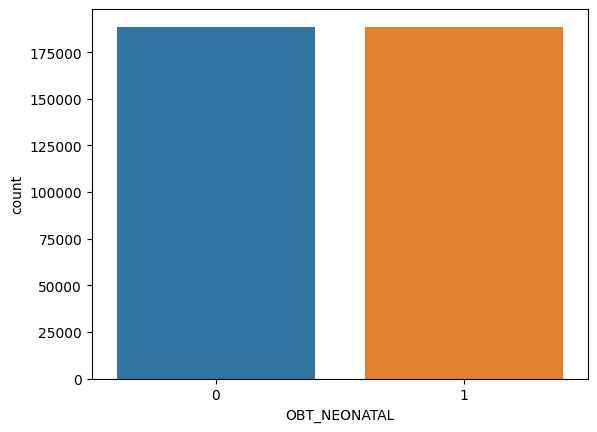

time: 347 ms (started: 2023-09-06 11:10:14 +00:00)


In [12]:
ax = sns.countplot(x='OBT_NEONATAL', data=data_bal)

##Dados de treino e de teste<hr style='border: 2px solid red;'>

In [13]:
from sklearn.model_selection import train_test_split

time: 515 µs (started: 2023-09-06 11:10:19 +00:00)


In [14]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X_bal, y_bal, test_size =0.3,
                                                        random_state=SEED,
                                                        shuffle=True,
                                                        stratify=y_bal)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(X_treino), len(X_teste)))
print()

Treinaremos com 264068 elementos e testaremos com 113172 elementos

time: 1.48 s (started: 2023-09-06 11:10:20 +00:00)


### Métodos auxiliares

In [15]:
def imprimir_metricas(_nome_modelo, _predito):
  print("A Acurácia do modelo {} foi {:.2f}%".format(_nome_modelo, (accuracy_score(y_teste, _predito) * 100)))
  print("A Precisão do modelo {} foi {:.2f}%".format(_nome_modelo, (precision_score(y_teste, _predito) * 100)))
  print("A Recall do modelo {} foi {:.2f}%".format(_nome_modelo, (recall_score(y_teste, _predito) * 100)))
  print("A F1 do modelo {} foi {:.2f}%".format(_nome_modelo, (f1_score(y_teste, _predito) * 100)))
  print()

time: 6.6 ms (started: 2023-09-06 11:10:24 +00:00)


In [16]:
def imprime_metrica_cv(_nome_modelo, _results):
    media = _results['test_score'].mean()
    desvio_padrao = _results['test_score'].std()
    ini = (media - 2 * desvio_padrao)*100
    fim = (media + 2 * desvio_padrao) * 100
    print("A Sensibilidade do modelo {} com Cross Validation foi  [{:.2f}%, {:.2f}%]".format(_nome_modelo, ini, fim))
    print()

time: 792 µs (started: 2023-09-06 11:10:26 +00:00)


In [17]:
  def tab_treino_teste_cv(max_depth, results):
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100
    tabela = [max_depth, train_score, test_score]
    return tabela

time: 830 µs (started: 2023-09-06 11:10:28 +00:00)


## <font style='font-size: 30px;'>Modelos Simples</font>
<hr style='border: 2px solid red;'>

### Dummy Classifier Stratified
<hr style='border: 2px solid red;'>

In [20]:
from sklearn.dummy import DummyClassifier

time: 572 µs (started: 2023-09-05 19:05:59 +00:00)


In [21]:
modelo_dummy_stratified = DummyClassifier(strategy='stratified')
modelo_dummy_stratified.fit(X_treino, y_treino)
predito_ds = modelo_dummy_stratified.predict(X_teste)

imprimir_metricas('Dummy Stratified', predito_ds)
print()

A Acurácia do modelo Dummy Stratified foi 49.87%
A Precisão do modelo Dummy Stratified foi 49.87%
A Recall do modelo Dummy Stratified foi 49.90%
A F1 do modelo Dummy Stratified foi 49.88%


time: 153 ms (started: 2023-09-05 19:06:01 +00:00)


### Dummy Classifier Most Frequence
<hr style='border: 2px solid red;'>

In [22]:
modelo_dummy_mostfrequent = DummyClassifier(strategy="most_frequent")
modelo_dummy_mostfrequent.fit(X_treino, y_treino)
predito_dmf = modelo_dummy_mostfrequent.predict(X_teste)

imprimir_metricas('Dummy Most Frequent', predito_dmf)

A Acurácia do modelo Dummy Most Frequent foi 50.00%
A Precisão do modelo Dummy Most Frequent foi 0.00%
A Recall do modelo Dummy Most Frequent foi 0.00%
A F1 do modelo Dummy Most Frequent foi 0.00%

time: 102 ms (started: 2023-09-05 19:06:03 +00:00)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Modelo Gradiente Descendente
<hr style='border: 2px solid red;'>

In [18]:
from sklearn.linear_model import SGDClassifier

time: 569 µs (started: 2023-09-06 11:11:06 +00:00)


In [20]:
pip_sgd = make_pipeline(StandardScaler(),
                        SGDClassifier(max_iter=1000, tol=1e-3, random_state=SEED))
pip_sgd.fit(X=X_treino, y=y_treino)
predito_sgd = pip_sgd.predict(X_teste)

imprimir_metricas('SGD', predito_sgd)

A Acurácia do modelo SGD foi 97.23%
A Precisão do modelo SGD foi 98.38%
A Recall do modelo SGD foi 96.04%
A F1 do modelo SGD foi 97.20%

time: 2.31 s (started: 2023-09-06 11:13:38 +00:00)


### Modelo SVC
<hr style='border: 2px solid red;'>

In [25]:
from sklearn.svm import SVC

time: 505 µs (started: 2023-09-05 19:06:13 +00:00)


In [26]:
modelo_svc = make_pipeline(StandardScaler(), SVC(gamma='auto', random_state = SEED))
modelo_svc.fit(X_treino, y_treino)
predito_svc = modelo_svc.predict(X_teste)

imprimir_metricas('SVC', predito_svc)

A Acurácia do modelo SVC foi 97.88%
A Precisão do modelo SVC foi 98.70%
A Recall do modelo SVC foi 97.04%
A F1 do modelo SVC foi 97.87%

time: 11min 8s (started: 2023-09-05 19:06:15 +00:00)


### KNN</font>
<hr style='border: 2px solid red;'>

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.DistanceMetric.html#sklearn.metrics.DistanceMetric

<font color="red">*Dados categóricos???*</font>

In [25]:
from sklearn.neighbors import KNeighborsClassifier

time: 508 µs (started: 2023-09-06 11:29:51 +00:00)


In [28]:
modelo_knn_euc = make_pipeline(StandardScaler(), KNeighborsClassifier(metric='euclidean'))
modelo_knn_euc.fit(X_treino, y_treino)
predito_knn_euc = modelo_knn_euc.predict(X_teste)

imprimir_metricas('KNN Euclidean', predito_knn_euc)

A Acurácia do modelo KNN Euclidean foi 99.30%
A Precisão do modelo KNN Euclidean foi 98.89%
A Recall do modelo KNN Euclidean foi 99.72%
A F1 do modelo KNN Euclidean foi 99.30%

time: 1min 54s (started: 2023-09-05 19:18:59 +00:00)


In [29]:
modelo_knn_man = make_pipeline(StandardScaler(), KNeighborsClassifier(metric='manhattan'))
modelo_knn_man.fit(X_treino, y_treino)
predito_knn_man = modelo_knn_man.predict(X_teste)

imprimir_metricas('KNN Manhattan', predito_knn_man)

A Acurácia do modelo KNN Manhattan foi 99.52%
A Precisão do modelo KNN Manhattan foi 99.30%
A Recall do modelo KNN Manhattan foi 99.75%
A F1 do modelo KNN Manhattan foi 99.52%

time: 13min 2s (started: 2023-09-05 19:20:54 +00:00)


In [30]:
modelo_knn_mi = make_pipeline(StandardScaler(), KNeighborsClassifier(metric='minkowski'))
modelo_knn_mi.fit(X_treino, y_treino)
predito_knn_mi = modelo_knn_mi.predict(X_teste)

imprimir_metricas('KNN Minkowski', predito_knn_mi)

A Acurácia do modelo KNN Minkowski foi 99.30%
A Precisão do modelo KNN Minkowski foi 98.89%
A Recall do modelo KNN Minkowski foi 99.72%
A F1 do modelo KNN Minkowski foi 99.30%

time: 2min 13s (started: 2023-09-05 19:33:57 +00:00)


In [31]:
modelo_knn_ch = make_pipeline(StandardScaler(), KNeighborsClassifier(metric='chebyshev'))
modelo_knn_ch.fit(X_treino, y_treino)
predito_knn_ch = modelo_knn_ch.predict(X_teste)

imprimir_metricas('KNN Chebyshev', predito_knn_ch)

A Acurácia do modelo KNN Chebyshev foi 98.98%
A Precisão do modelo KNN Chebyshev foi 98.32%
A Recall do modelo KNN Chebyshev foi 99.66%
A F1 do modelo KNN Chebyshev foi 98.99%

time: 8min 52s (started: 2023-09-05 19:36:10 +00:00)


### Árvore de decisão
<hr style='border: 2px solid red;'>

<font color="red">*Definir profundidade*</font>

In [32]:
from sklearn.tree import DecisionTreeClassifier

time: 534 µs (started: 2023-09-05 19:47:25 +00:00)


In [33]:
modelo_dtc = make_pipeline(DecisionTreeClassifier())
modelo_dtc.fit(X_treino, y_treino)
predito_dtc = modelo_dtc.predict(X_teste)

imprimir_metricas('Decision Tree', predito_dtc)

A Acurácia do modelo Decision Tree foi 99.49%
A Precisão do modelo Decision Tree foi 99.41%
A Recall do modelo Decision Tree foi 99.57%
A F1 do modelo Decision Tree foi 99.49%

time: 4.41 s (started: 2023-09-05 19:47:27 +00:00)


### <font style='font-size: 30px;'>Random Forest</font>
<hr style='border: 2px solid red;'>

In [34]:
from sklearn.ensemble import RandomForestClassifier

time: 539 µs (started: 2023-09-05 19:47:31 +00:00)


In [35]:
modelo_rfc = make_pipeline(RandomForestClassifier(n_estimators = 100))
modelo_rfc.fit(X_treino, y_treino)
predito_rfc = modelo_rfc.predict(X_teste)

imprimir_metricas('Random Forest', predito_rfc)
print()

A Acurácia do modelo Random Forest foi 99.73%
A Precisão do modelo Random Forest foi 99.81%
A Recall do modelo Random Forest foi 99.65%
A F1 do modelo Random Forest foi 99.73%


time: 42.4 s (started: 2023-09-05 19:47:31 +00:00)


## Modelos Cross Validate

In [31]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

from sklearn.model_selection import StratifiedKFold

from sklearn import metrics

time: 918 µs (started: 2023-09-06 12:05:40 +00:00)


### SGD Cross Validate
<hr style='border: 2px solid red;'>

In [38]:
cv = StratifiedKFold(n_splits = 10, shuffle=True)
pip_sgd = make_pipeline(StandardScaler(),
                        SGDClassifier(max_iter=1000, tol=1e-3, random_state=SEED))
results = cross_validate(pip_sgd, X_treino, y_treino, cv = cv, scoring='recall',return_train_score=False)

imprime_metrica_cv('Gradiente Descendente', results)

A Sensibilidade do modelo Gradiente Descendente com Cross Validation foi  [95.48%, 96.25%]

time: 8.44 s (started: 2023-09-06 12:36:12 +00:00)


[Text(0.5, 1.0, 'Confusion Matrix')]

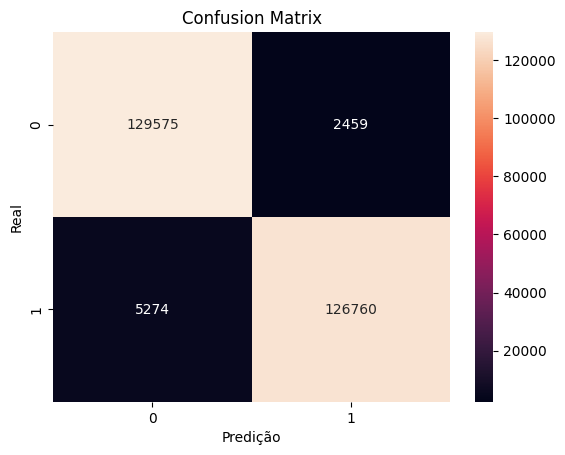

time: 7.25 s (started: 2023-09-06 12:46:10 +00:00)


In [48]:
y_treino_predit = cross_val_predict(pip_sgd, X_treino, y_treino, cv = cv)
ax = sns.heatmap(data=metrics.confusion_matrix(y_treino, y_treino_predit), annot = True, fmt = "d")
ax.set(xlabel = "Predição", ylabel = "Real")
ax.set(title='Confusion Matrix')

### KNN Cross Validate
<hr style='border: 2px solid red;'>

In [26]:
cv = StratifiedKFold(n_splits = 10, shuffle=True)
pip_knn = make_pipeline(StandardScaler(),
                        KNeighborsClassifier(metric='euclidean'))
results = cross_validate(pip_knn, X_treino, y_treino, cv = cv, scoring='recall',return_train_score=False)

imprime_metrica_cv('KNN', results)

A Sensibilidade do modelo KNN com Cross Validation foi  [99.61%, 99.80%]

time: 6min 19s (started: 2023-09-06 11:29:58 +00:00)


[Text(0.5, 1.0, 'Confusion Matrix')]

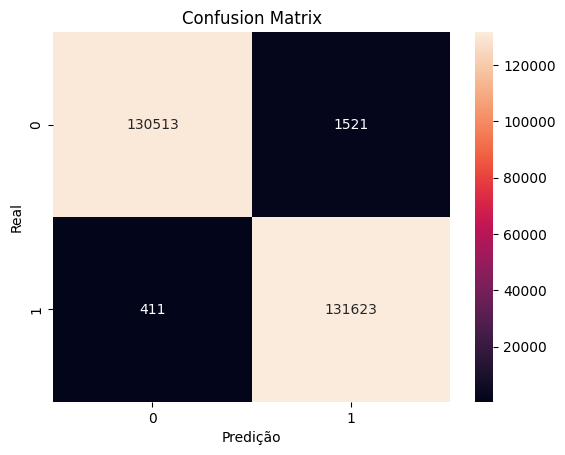

time: 6min 20s (started: 2023-09-06 12:46:46 +00:00)


In [49]:
y_treino_predit = cross_val_predict(pip_knn, X_treino, y_treino, cv = cv)
ax = sns.heatmap(data=metrics.confusion_matrix(y_treino, y_treino_predit), annot = True, fmt = "d")
ax.set(xlabel = "Predição", ylabel = "Real")
ax.set(title='Confusion Matrix')

### Árvore de Decisão Cross Validate
<hr style='border: 2px solid red;'>

In [52]:
from sklearn.tree import DecisionTreeClassifier

time: 630 µs (started: 2023-09-06 13:02:06 +00:00)


In [53]:
cv = StratifiedKFold(n_splits = 10, shuffle=True)
modelo_dtc_cv = DecisionTreeClassifier()
results = cross_validate(modelo_dtc_cv, X_treino, y_treino, cv = cv, scoring='recall',return_train_score=False)

imprime_metrica_cv('Decision Tree', results)

A Sensibilidade do modelo Decision Tree com Cross Validation foi  [99.46%, 99.70%]

time: 28 s (started: 2023-09-06 13:02:09 +00:00)


[Text(0.5, 1.0, 'Confusion Matrix')]

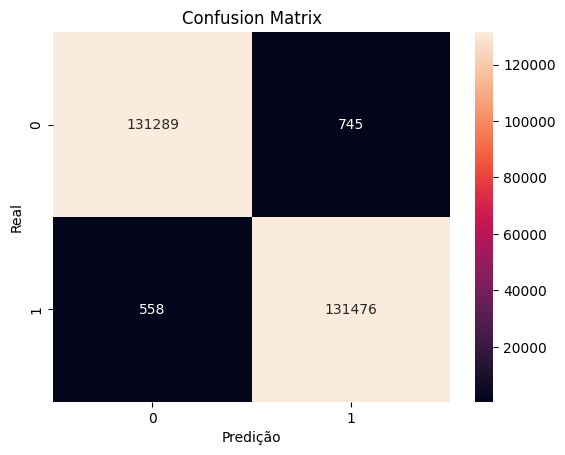

time: 25.4 s (started: 2023-09-06 13:02:47 +00:00)


In [54]:
y_treino_predit = cross_val_predict(modelo_dtc_cv, X_treino, y_treino, cv = cv)
ax = sns.heatmap(data=metrics.confusion_matrix(y_treino, y_treino_predit), annot = True, fmt = "d")
ax.set(xlabel = "Predição", ylabel = "Real")
ax.set(title='Confusion Matrix')

### <font style='font-size: 30px;'>Random Forest Cross Validate</font>
<hr style='border: 2px solid red;'>

In [58]:
from sklearn.ensemble import RandomForestClassifier

time: 511 µs (started: 2023-09-06 13:04:55 +00:00)


In [59]:
cv_rf = StratifiedKFold(n_splits = 10, shuffle=True)
modelo_rf_cv = RandomForestClassifier(n_estimators = 100)
results = cross_validate(modelo_rf_cv, X_treino, y_treino, cv = cv_rf, scoring='recall', return_train_score=False)

imprime_metrica_cv('Random Forest', results)

A Sensibilidade do modelo Random Forest com Cross Validation foi  [99.56%, 99.78%]

time: 6min 9s (started: 2023-09-06 13:04:58 +00:00)


[Text(0.5, 1.0, 'Confusion Matrix')]

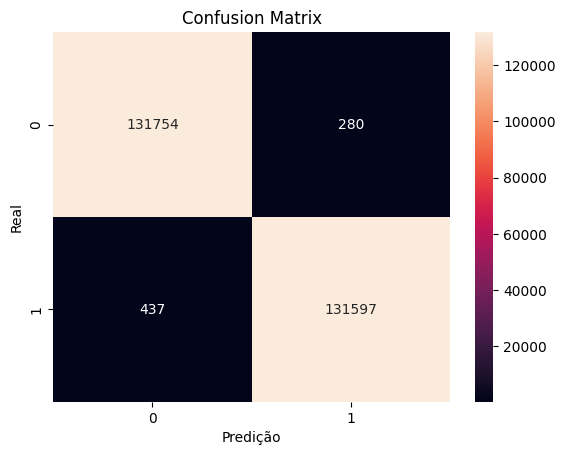

time: 6min 6s (started: 2023-09-06 13:11:08 +00:00)


In [60]:
y_treino_predit = cross_val_predict(modelo_rf_cv, X_treino, y_treino, cv = cv)
ax = sns.heatmap(data=metrics.confusion_matrix(y_treino, y_treino_predit), annot = True, fmt = "d")
ax.set(xlabel = "Predição", ylabel = "Real")
ax.set(title='Confusion Matrix')

## Modelos Hiper Parâmetros

### <font style='font-size: 30px;'>Árvore de Decisão Cross Validate Max-depht</font>
<hr style='border: 2px solid red;'>

In [47]:
def rodar_arvore_decisao(max_depth):
  cv = StratifiedKFold(n_splits = 10, shuffle=True)
  modelo_dtc_cv = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo_dtc_cv, X_treino, y_treino, cv = cv, scoring='recall', return_train_score=True)

  return tab_treino_teste_cv(max_depth, results)

time: 932 µs (started: 2023-09-05 20:09:52 +00:00)


In [48]:
resultados = [rodar_arvore_decisao(i) for i in range (1, 24)]
resultados = pd.DataFrame(resultados, columns = ["max_depth", "train", "test"])

time: 7min 1s (started: 2023-09-05 20:09:55 +00:00)


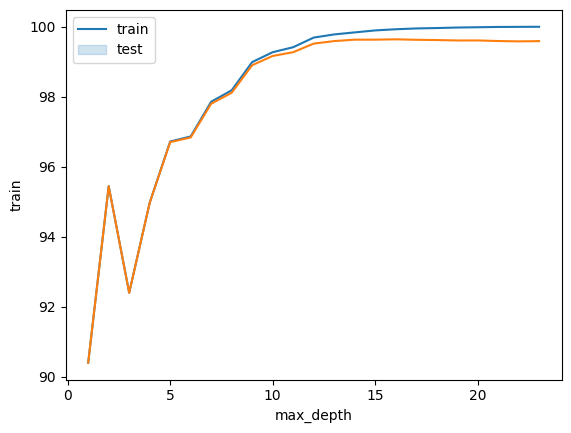

time: 251 ms (started: 2023-09-05 20:16:57 +00:00)


In [49]:
sns.lineplot(x = "max_depth", y = "train", data = resultados)
sns.lineplot(x = "max_depth", y = "test", data = resultados)
plt.legend(["train", "test"])

<font color="red">*Definir estimadores*</font>

### <font style='font-size: 30px;'>Random Forest Max deph</font>
<hr style='border: 2px solid red;'>

In [51]:
def rodar_random_forest(max_depth):
  cv = StratifiedKFold(n_splits = 10, shuffle=True)
  modelo_rf_cv = RandomForestClassifier(n_estimators = 100, max_depth=max_depth)
  results = cross_validate(modelo_rf_cv, X_treino, y_treino, cv = cv, scoring='recall', return_train_score=True)

  return tab_treino_teste_cv(max_depth, results)

time: 741 µs (started: 2023-09-05 20:22:28 +00:00)


In [52]:
resultados = [rodar_random_forest(i) for i in range (1, 24)]
resultados = pd.DataFrame(resultados, columns = ["max_depth", "train", "test"])

time: 1h 46min 37s (started: 2023-09-05 20:22:28 +00:00)


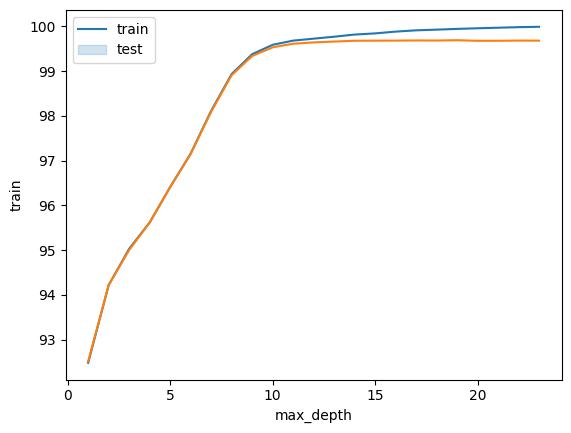

time: 322 ms (started: 2023-09-05 22:09:05 +00:00)


In [53]:
sns.lineplot(x = "max_depth", y = "train", data = resultados)
sns.lineplot(x = "max_depth", y = "test", data = resultados)
plt.legend(["train", "test"])

## Escolhendo o melhor modelo<hr style='border: 2px solid red;'>

**Métrica escolhida:**

**Random Forest**

Acurácia: 99.74%

Precisão: 99.81%

Recall: 99.67% < knn

F1: 99.74%

time: 2.38 s (started: 2023-09-05 17:49:23 +00:00)
